# Predicting CTRs in Email Marketing

## Intro

This notebook will attempt to model and predict Click Through Rates (CTR) from a dataset containing performance in past campaigns along with several features related to the composition of those campaigns.

## Data Wrangling

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [15]:
train = pd.read_csv("csv/train_F3fUq2S.csv")

In [56]:
train.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,1,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,0,2,11,...,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,1,2,11,...,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,2,15,9,...,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,1,6,26,...,0,0,1,0,0,0,0,0,14,0.142826


In [17]:
train.shape

(1888, 22)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [19]:
train.isna().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

In [20]:
train.nunique()

campaign_id           1888
sender                  12
subject_len            170
body_len              1568
mean_paragraph_len     121
day_of_week              7
is_weekend               2
times_of_day             3
category                16
product                 43
no_of_CTA               40
mean_CTA_len            79
is_image                 6
is_personalised          2
is_quote                 7
is_timer                 1
is_emoticons             6
is_discount              2
is_price                 8
is_urgency               2
target_audience         17
click_rate            1810
dtype: int64

In [21]:
train['times_of_day'].replace({'Morning': 0, 'Noon': 1, 'Evening': 2}, inplace=True)

In [57]:
train = train.drop(['is_timer'], axis=1)

## Exploratory Data Analysis

The target variable for this analysis is 'click_rate', which measures the number of clicks on Calls To Action in a given email divided by the number of times the email was opened.

First, we examine the CTR to get a sense of average and outliers.

In [58]:
train['click_rate'].describe()

count    1888.000000
mean        0.041888
std         0.084223
min         0.000000
25%         0.005413
50%         0.010686
75%         0.035589
max         0.897959
Name: click_rate, dtype: float64

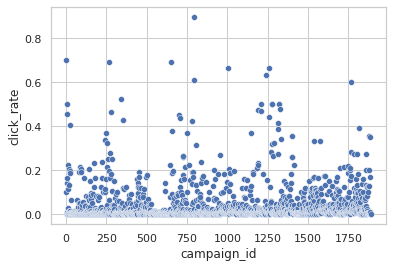

In [59]:
sns.set(style='whitegrid')

_ = sns.scatterplot(x='campaign_id', y='click_rate', data=train)

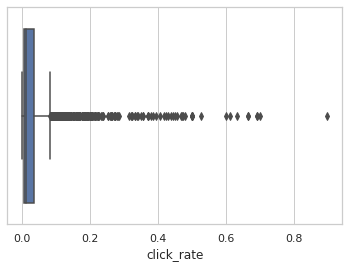

In [60]:
_ = sns.boxplot(x='click_rate', data=train)

It's worth taking a look at the distribution of CTRs, with the most extreme outlier removed.

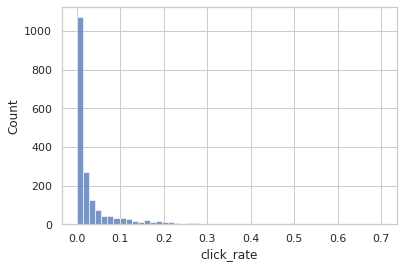

In [61]:
_ = sns.histplot(data=train.loc[train['click_rate']!=train['click_rate'].max()], x='click_rate', bins=50)

The data are heavily right-skewed with most CTR values clustered around small numbers. We'll take the log of the variable to get a better look. We also have to handle the zero value CTRs while doing so.

In [62]:
np.seterr(divide = 'ignore')
ctr_log = np.where(train['click_rate']>0, np.log(train['click_rate']), 0)

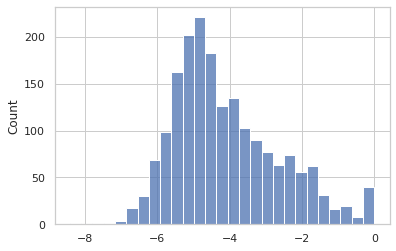

In [63]:
_ = sns.histplot(ctr_log)

With a somewhat more wieldy distribution to work with, let's see how other features relate to CTRs. In marketing, it's common to adjust the time an email is sent, the length of the email, and the length of the subject line. Are there any apparent trends with these features vis click rate?

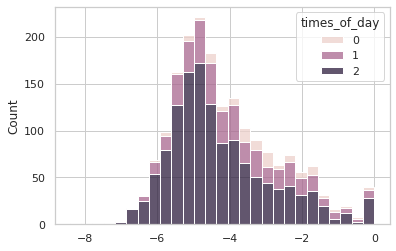

In [64]:
_ = sns.histplot(data=train, x=ctr_log, hue='times_of_day', multiple='stack')

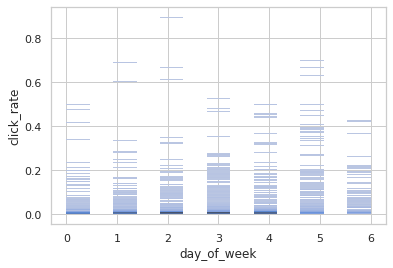

In [65]:
_ = sns.histplot(data=train, x='day_of_week', y='click_rate')

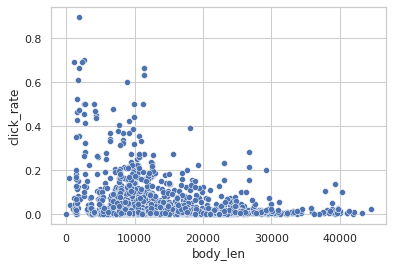

In [66]:
_ = sns.scatterplot(data=train, x='body_len', y='click_rate')

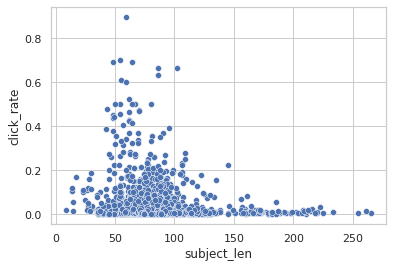

In [67]:
_ = sns.scatterplot(data=train, x='subject_len', y='click_rate')

It looks like time of day isn't so important, but there might be some wisdom to sending email campaigns during or close to the weekends. There appears to be an inverse correlation between length - both in subject and body - and click rate. While we're in that area, let's look at the overall correlation map.

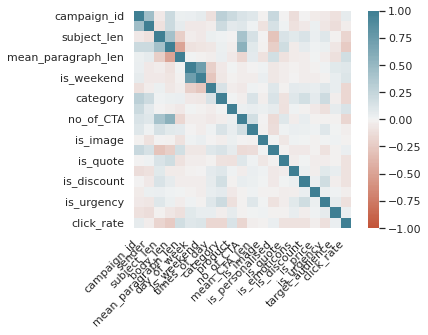

In [84]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


Sure enough, the length features, plus the number of CTAs present in the email, look to be negatively correlated with the target variable. Mean paragraph length may be positively correlated. Are the best emails short and dense?

I suspect there may be some collinearity, especially between the length variables.

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]

vif_data

,feature,VIF
0,campaign_id,6.330514
1,sender,3.785089
2,subject_len,12.074559
3,body_len,10.162461
4,mean_paragraph_len,3.262885
5,day_of_week,7.242060
6,is_weekend,2.738495
7,times_of_day,8.268105
8,category,5.843311
9,product,3.305466


## Preprocessing

Standardizing features will be important here. Several categorical variables such as "is_image" are already encoded in a binary, but others like "time_of_day" will need to be one-hot encoded before modeling.

In [102]:
# Changing naming convention of DataFrame to 'df' to avoid confusion when doing train_test_split later.

train['times_of_day'].replace({0: 'Morning', 1: 'Noon', 2: 'Evening'}, inplace=True)
train['day_of_week'].replace({0:'mon', 1:'tues', 2:'weds', 3:'thurs', 4:'fri', 5:'sat', 6:'sun'}, inplace=True)

dfo = train.select_dtypes(include=['object'])
df = pd.concat([train.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

df

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,is_weekend,category,product,no_of_CTA,mean_CTA_len,...,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thurs,day_of_week_tues,day_of_week_weds,times_of_day_Evening,times_of_day_Morning,times_of_day_Noon
0,1,3,76,10439,39,1,6,26,3,29,...,0,0,1,0,0,0,0,0,0,1
1,2,3,54,2570,256,1,2,11,0,22,...,0,0,1,0,0,0,0,0,1,0
2,3,3,59,12801,16,1,2,11,3,23,...,0,0,1,0,0,0,0,0,0,1
3,4,3,74,11037,30,0,15,9,4,24,...,1,0,0,0,0,0,0,1,0,0
4,5,3,80,10011,27,1,6,26,3,31,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1884,3,88,1451,75,0,2,11,0,22,...,0,0,0,0,0,0,1,0,0,1
1884,1885,3,58,10537,40,0,2,11,5,27,...,0,0,0,0,0,0,1,1,0,0
1885,1886,3,89,11050,26,0,15,9,4,28,...,0,0,0,0,0,1,0,1,0,0
1886,1887,3,58,10537,40,0,2,11,5,27,...,0,0,0,0,0,1,0,1,0,0


In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

names = list(df.columns)

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

With the other preprocessing steps completed, and scaling done on the full set of X, it's time to perform a train/test split. I will eventually want to create a model that predicts CTR, so 'click_rate' will be my designated Y / target feature.

In [ ]:
from sklearn.model_selection import train_test_split

y = scaled_df['click_rate']
X = df.drop(columns = ['click_rate'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)